In [1]:
# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Tools
import numpy as np
from astropy.table import Table,vstack
import pickle
import time
import matplotlib.pyplot as plt
import scipy.optimize as op
import sys
import time

# The Payne, see https://github.com/tingyuansen/The_Payne for more details
from The_Payne import training
from The_Payne import utils
from The_Payne import spectral_model

In [2]:
# That's how we would do it:
# training_labels, training_spectra, validation_labels, validation_spectra = utils.load_training_data()
"""
Changes that need to be made to training.py in The_Payne if no CUDA is available

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    dtype = torch.FloatTensor
    torch.set_default_tensor_type('torch.FloatTensor')
    
if torch.cuda.is_available():
    model.cuda()
        
if torch.cuda.is_available():
    perm = perm.cuda()
"""
# That's how we do it:

"\nChanges that need to be made to training.py in The_Payne if no CUDA is available\n\nif torch.cuda.is_available():\n    dtype = torch.cuda.FloatTensor\n    torch.set_default_tensor_type('torch.cuda.FloatTensor')\nelse:\n    dtype = torch.FloatTensor\n    torch.set_default_tensor_type('torch.FloatTensor')\n    \nif torch.cuda.is_available():\n    model.cuda()\n        \nif torch.cuda.is_available():\n    perm = perm.cuda()\n"

In [3]:
# choose one grid_index
try:
    grid_index = int(sys.argv[1])
    print('Using Grid index ',grid_index)
except:
    grid_index = 1931
    #grid_index = 1259
    print('Using default grid index ',grid_index)

Using default grid index  1931


In [4]:
grids = Table.read('../../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')

teff_logg_feh_name = str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index])

# Let's save our default 7 models
seven_grids = np.array([
    str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]),
    str(int(grids['teff_low_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]),
    str(int(grids['teff_high_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]),
    str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_low_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]),
    str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_high_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]),
    str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_low_subgrid'][grid_index]),
    str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_high_subgrid'][grid_index])   
])

# Not all of the default models have to exist (e.g. for logg == 5.0)
# In that case, replace them with the middle grid to give more weight to it.

for seven_grid_index in range(len(seven_grids)):
    try:
        training_set = Table.read('../training_input/'+seven_grids[seven_grid_index]+'/galah_dr4_trainingset_'+seven_grids[seven_grid_index]+'_incl_vsini.fits')
    except:
        print('No grid available for '+seven_grids[seven_grid_index]+', replacing with '+str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index]))
        seven_grids[seven_grid_index] = str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index])

print(seven_grids)

training_labels = []
training_set_flux = []

wavelength_file = '../training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
wavelength_array = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

for seven_teff_logg_feh_name in seven_grids:
    training_set_one = Table.read('../training_input/'+seven_teff_logg_feh_name+'/galah_dr4_trainingset_'+seven_teff_logg_feh_name+'_incl_vsini.fits')
    
    labels = tuple(training_set.keys()[2:-1])

    training_labels.append(np.array([training_set_one[label] for label in labels]).T)

    masks = Table.read('../training_input/'+seven_teff_logg_feh_name+'/'+seven_teff_logg_feh_name+'_masks.fits')
    
    flux_ivar_file = '../training_input/'+seven_teff_logg_feh_name+'/galah_dr4_trainingset_'+seven_teff_logg_feh_name+'_incl_vsini_flux_ivar.pickle'
    flux_ivar_file_opener = open(flux_ivar_file,'rb')
    training_set_flux.append(pickle.load(flux_ivar_file_opener))
    flux_ivar_file_opener.close()

training_labels = np.concatenate((training_labels))
training_set_flux = np.concatenate((training_set_flux))

No grid available for 5750_5.00_0.00, replacing with 5750_4.50_0.00
['5750_4.50_0.00' '5500_4.50_0.00' '6000_4.50_0.00' '5750_4.00_0.00'
 '5750_4.50_0.00' '5750_4.50_-0.25' '5750_4.50_0.25']


In [5]:
labels = tuple(training_set.keys()[2:-1])

print('Labels to be fitted: ',len(labels))
print(labels)

Labels to be fitted:  36
('teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe')


In [6]:
model_file = 'galah_dr4_thepayne_model_extra6_'+teff_logg_feh_name+'_'+str(len(labels))+'labels'

print('Will create The Payne model to be stored at ')
print('models/'+model_file+'.model')

Will create The Payne model to be stored at 
models/galah_dr4_thepayne_model_extra6_5750_4.50_0.00_36labels.model


In [37]:
from sklearn.model_selection import train_test_split

# We will split the data set into 90% training set and 10% validation set
# To allow to reproduce that, we will use a reproducable random_state computed from teff/logg/fe_h
train, test = train_test_split(np.arange(np.shape(training_set_flux)[0]), test_size=0.1, random_state=int(grids['teff_subgrid'][grid_index])+int(10*grids['logg_subgrid'][grid_index])+int(100*grids['fe_h_subgrid'][grid_index]))

In [ ]:
training.neural_net(
    training_labels = training_labels[train,:], 
    training_spectra = training_set_flux[train,:],
    validation_labels = training_labels[test,:], 
    validation_spectra = training_set_flux[test,:],
    num_neurons=300,
    learning_rate=1e-4,
    num_steps=1e4,
    batch_size=128,#np.min([256,np.int(np.shape(training_labels)[1]/2.)]), 
    num_pixel=np.shape(training_set_flux[0])[0],
    training_loss_name = 'loss_functions/'+model_file+'_loss.npz',
    payne_model_name = 'models/'+model_file+'.npz'
    )

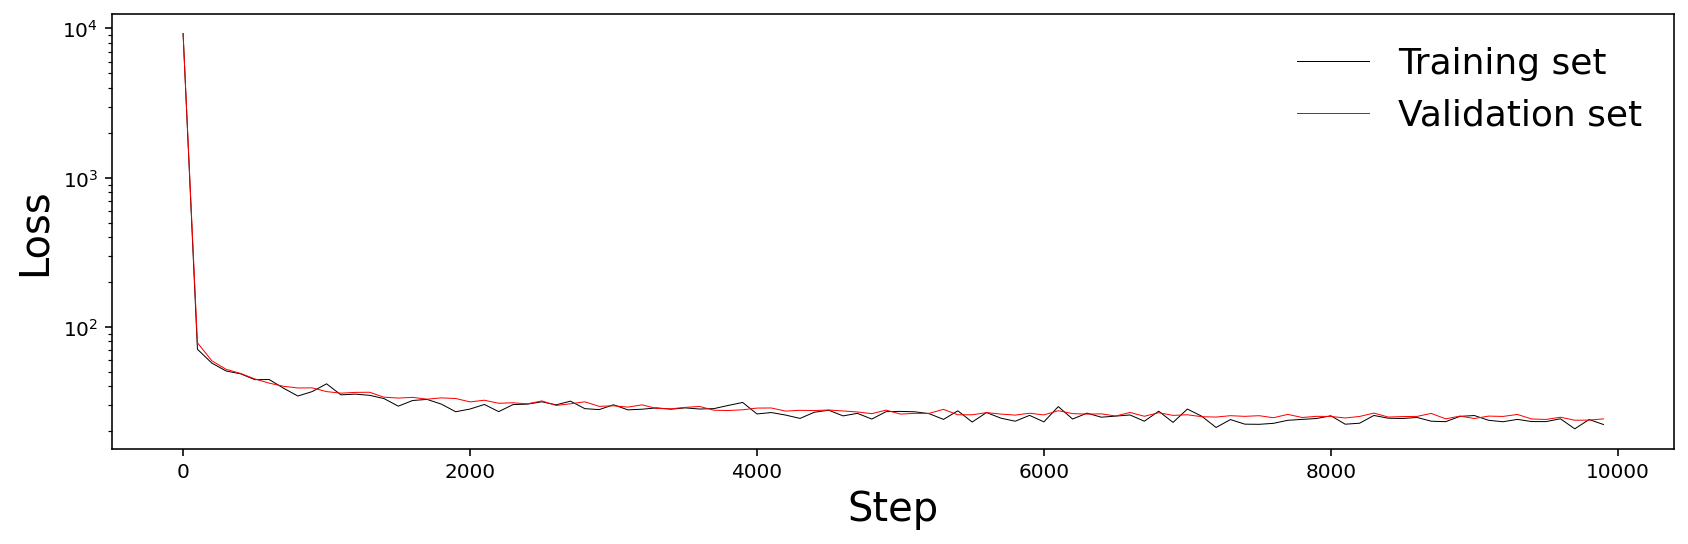

In [7]:
tmp = np.load('loss_functions/'+model_file+'_loss.npz') # the output array also stores the training and validation loss
training_loss = tmp["training_loss"]
validation_loss = tmp["validation_loss"]

plt.figure(figsize=(14, 4))
plt.plot(np.arange(training_loss.size)*100, training_loss, 'k', lw=0.5, label = 'Training set')
plt.plot(np.arange(training_loss.size)*100, validation_loss, 'r', lw=0.5, label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 18)
plt.yscale('log')
#plt.ylim([5,100])
plt.xlabel("Step", size=20)
plt.ylabel("Loss", size=20)
plt.savefig('loss_functions/'+model_file+'_loss.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# For validation purposes, we can recreate some training spectra

In [9]:
plot_validation = True

In [10]:
def load_dr3_lines(mode_dr3_path = '../../spectrum_analysis/spectrum_masks/important_lines'):
    """
    
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    print('Trying to read in list of elements run as part of DR3')
    line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
    print('Success')
        
    return(important_lines,important_molecules)

def plot_spectrum(wave,flux,flux_uncertainty,title_text):
    """
    Let's plot a spectrum, that is, flux over wavelenth
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    subplot_wavelengths = np.array([
        [4700,4775],
        [4770,4850],
        [4840,4900],
        [5600,5730],
        [5720,5805],
        [5795,6000],
        [6400,6600],
        [6590,6670],
        [6660,6739],
        [7600,7720],
        [7710,7820],
        [7810,7900]
    ])
    
    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7),sharey=True)
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave > subplot_wavelengths[subplot,0]) & (wave < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        
        # if only 1 spectrum
        if flux_array_indices == 1:
            ax.plot(wave[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5);
        else:
            for index in range(flux_array_indices):
                if index == 0:
                    ax.plot(wave[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                    ax.plot(wave[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                if index == 1:
                    ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='C0',label='model (initial)');
                    ax.plot(wave[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
            if subplot == nr_subplots-1:
                ax.legend(ncol=2,loc='lower right',fontsize=6)
                
        maski = 0
        for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end']):
            if (mask_beginning > wave[in_subplot_wavelength_range][0]) & (mask_end < wave[in_subplot_wavelength_range][-1]):
                if maski == 0:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1)
        each_index = 0 
        for each_element in important_lines:
            if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):
            
                offset = -0.05+0.1*(each_index%3)
                each_index+=1
                ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                if each_element[1] in ['Li','C','O']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                elif each_element[1] in ['Na','Al','K']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')
        ax.set_ylim(-0.1,1.2)
        if subplot == 11:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.axhline(1.05,lw=0.5,color='k')
        ax.set_ylabel('Flux / norm.')
    f.suptitle(title_text)
    plt.tight_layout(h_pad=0)
    
    return f

def plot_validation_spectra(index):
    
    default_labels = (training_labels[index]-x_min)/(x_max-x_min) - 0.5

    default_model = spectral_model.get_spectrum_from_neural_net(scaled_labels = default_labels, NN_coeffs = NN_coeffs)

    f = plot_spectrum(
        wavelength_array,
        [training_set_flux[index],default_model],
        np.zeros(len(default_model)),
        str(index)+': '+
        'Teff='+str(int(np.round(training_labels[index,0])))+'K, '+
        'logg='+str(np.round(training_labels[index,1],decimals=2))+', '+
        '[Fe/H]='+str(np.round(training_labels[index,2],decimals=2))+', '+
        'vmic='+str(np.round(training_labels[index,3],decimals=2))+'km/s, '+
        'vsini='+str(np.round(training_labels[index,4],decimals=1))+'km/s'
    )
    f.savefig('validation_spectra/ThePayne_Spectrum_Grid'+str(grid_index)+'_'+str(index)+'.pdf',bbox_inches='tight')
    plt.close()

In [11]:
if plot_validation:
    
    tmp = np.load('models/'+model_file+'.npz')
    w_array_0 = tmp["w_array_0"]
    w_array_1 = tmp["w_array_1"]
    w_array_2 = tmp["w_array_2"]
    b_array_0 = tmp["b_array_0"]
    b_array_1 = tmp["b_array_1"]
    b_array_2 = tmp["b_array_2"]
    x_min = tmp["x_min"]
    x_max = tmp["x_max"]
    tmp.close()
    NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

    # Load some important lines
    important_lines, important_molecules = load_dr3_lines()

    # Load Spectrum masks
    masks = Table.read('../../spectrum_analysis/spectrum_masks/solar_spectrum_mask.fits')

    for index in range(37):
        plot_validation_spectra(index)

    for index in np.arange(50,1700,50):
        plot_validation_spectra(index)

Trying to read in list of elements run as part of DR3
Success
